In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
# Machine Learning libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

In [4]:
# Deep Learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping


In [5]:
# Prophet
from prophet import Prophet

# Additional libraries for innovative techniques
from scipy import stats
import itertools

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

In [7]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [8]:
# Load the data
df = pd.read_csv('department_17_sales.csv')

In [9]:
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

Dataset Shape: (143, 8)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          143 non-null    object 
 1   IsHoliday     143 non-null    int64  
 2   Dept          143 non-null    float64
 3   Weekly_Sales  143 non-null    float64
 4   Temperature   143 non-null    float64
 5   Fuel_Price    143 non-null    float64
 6   CPI           143 non-null    float64
 7   Unemployment  143 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 9.1+ KB
None

First 5 rows:
         Date  IsHoliday  Dept  Weekly_Sales  Temperature  Fuel_Price  \
0  2010-02-05          0  17.0      13223.76        42.31       2.572   
1  2010-02-12          1  17.0      13403.66        38.51       2.548   
2  2010-02-19          0  17.0      13485.61        39.93       2.514   
3  2010-02-26          0  17.0      10667.06        4

In [10]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


In [11]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())



Missing values:
IsHoliday       0
Dept            0
Weekly_Sales    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


In [12]:
# Basic statistics
print("\nBasic Statistics:")
print(df.describe())


Basic Statistics:
        IsHoliday   Dept  Weekly_Sales  Temperature  Fuel_Price         CPI  \
count  143.000000  143.0    143.000000   143.000000  143.000000  143.000000   
mean     0.069930   17.0   9196.557902    68.306783    3.219699  215.996892   
std      0.255926    0.0   2025.029196    14.250486    0.427313    4.350890   
min      0.000000   17.0   5913.510000    35.400000    2.514000  210.337426   
25%      0.000000   17.0   7881.505000    58.265000    2.764500  211.549277   
50%      0.000000   17.0   8712.440000    69.640000    3.290000  215.459905   
75%      0.000000   17.0   9972.620000    80.485000    3.594000  220.531330   
max      1.000000   17.0  19842.000000    91.650000    3.907000  223.444251   

       Unemployment  
count    143.000000  
mean       7.610420  
std        0.383749  
min        6.573000  
25%        7.348000  
50%        7.787000  
75%        7.838000  
max        8.106000  


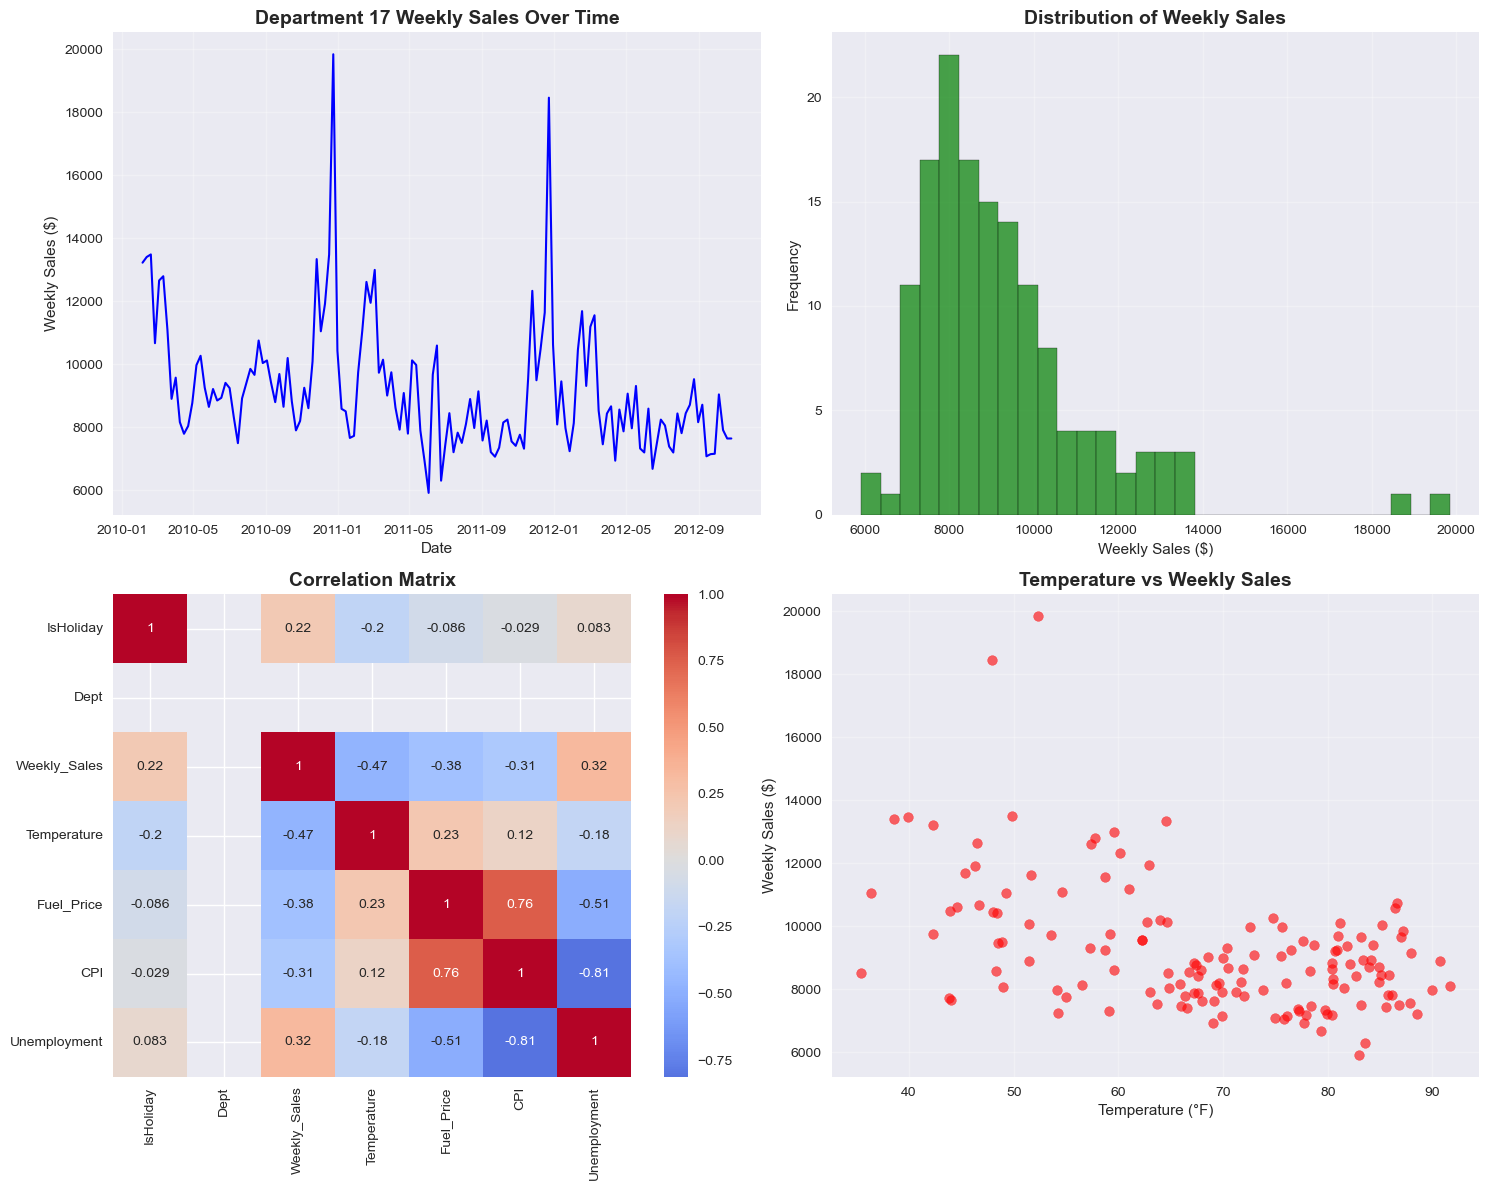

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Time series of Weekly Sales
axes[0, 0].plot(df.index, df['Weekly_Sales'], linewidth=1.5, color='blue')
axes[0, 0].set_title('Department 17 Weekly Sales Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Weekly Sales ($)')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Sales distribution
axes[0, 1].hist(df['Weekly_Sales'], bins=30, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_title('Distribution of Weekly Sales', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Weekly Sales ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Correlation heatmap
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 0])
axes[1, 0].set_title('Correlation Matrix', fontsize=14, fontweight='bold')

# Plot 4: External factors vs Sales
axes[1, 1].scatter(df['Temperature'], df['Weekly_Sales'], alpha=0.6, color='red')
axes[1, 1].set_title('Temperature vs Weekly Sales', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Temperature (°F)')
axes[1, 1].set_ylabel('Weekly Sales ($)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [14]:
# Holiday analysis
print("\nHoliday vs Non-Holiday Sales:")
holiday_stats = df.groupby('IsHoliday')['Weekly_Sales'].agg(['mean', 'std', 'count'])
print(holiday_stats)


Holiday vs Non-Holiday Sales:
                   mean          std  count
IsHoliday                                  
0           9076.149624  1995.852556    133
1          10797.988000  1792.548854     10


TIME SERIES DECOMPOSITION


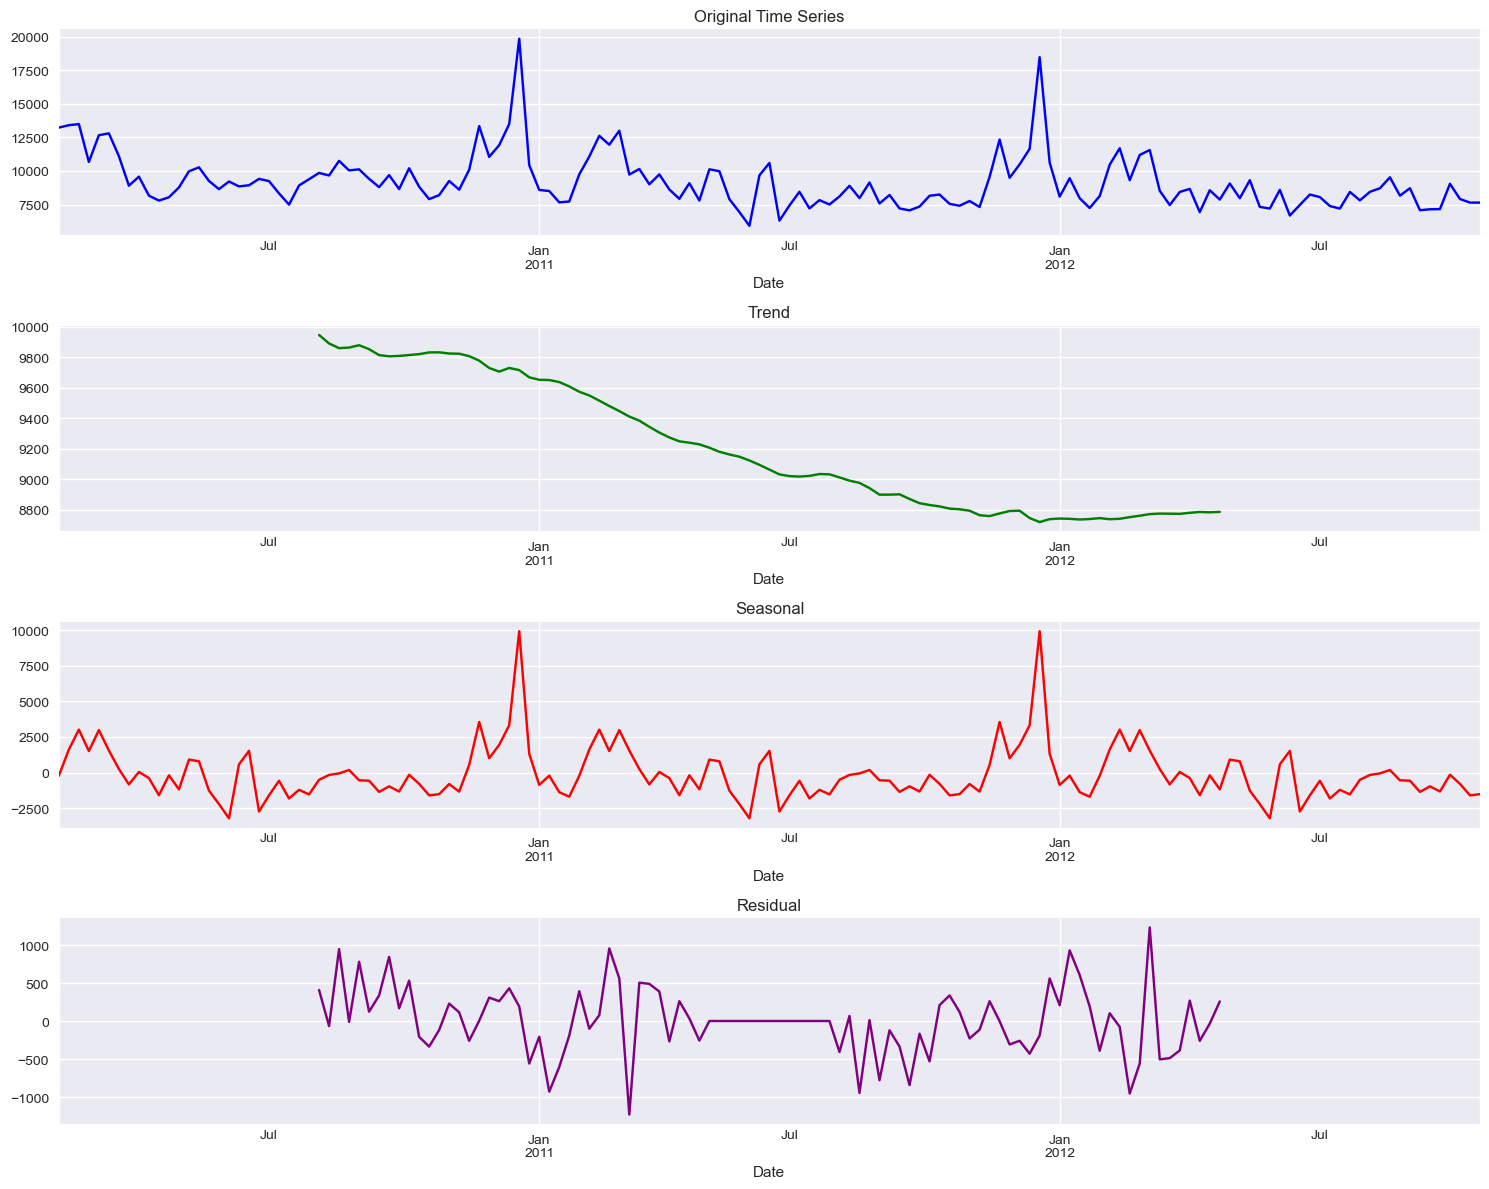

In [15]:
print("TIME SERIES DECOMPOSITION")
# Perform seasonal decomposition
decomposition = seasonal_decompose(df['Weekly_Sales'], 
                                 model='additive', 
                                 period=52)  # Weekly data, yearly seasonality

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

decomposition.observed.plot(ax=axes[0], title='Original Time Series', color='blue')
decomposition.trend.plot(ax=axes[1], title='Trend', color='green')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal', color='red')
decomposition.resid.plot(ax=axes[3], title='Residual', color='purple')

plt.tight_layout()
plt.show()


In [16]:
print("STATIONARITY TESTS AND ACF/PACF ANALYSIS")
def check_stationarity(timeseries, title):
    """Check stationarity using Augmented Dickey-Fuller test"""
    print(f"\nStationarity Test for {title}:")
    print("-" * 40)
    
    # Perform Augmented Dickey-Fuller test
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    
    print(f'ADF Statistic: {dftest[0]:.6f}')
    print(f'p-value: {dftest[1]:.6f}')
    print(f'Critical Values:')
    for key, value in dftest[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if dftest[1] <= 0.05:
        print("Series is stationary (reject null hypothesis)")
    else:
        print("Series is non-stationary (fail to reject null hypothesis)")
# Test original series
check_stationarity(df['Weekly_Sales'], "Original Series")


STATIONARITY TESTS AND ACF/PACF ANALYSIS

Stationarity Test for Original Series:
----------------------------------------
ADF Statistic: -6.317095
p-value: 0.000000
Critical Values:
	1%: -3.477
	5%: -2.882
	10%: -2.578
Series is stationary (reject null hypothesis)


In [17]:
# Test differenced series
df['Sales_diff'] = df['Weekly_Sales'].diff()
check_stationarity(df['Sales_diff'], "First Differenced Series")


Stationarity Test for First Differenced Series:
----------------------------------------
ADF Statistic: -7.374342
p-value: 0.000000
Critical Values:
	1%: -3.481
	5%: -2.884
	10%: -2.578
Series is stationary (reject null hypothesis)


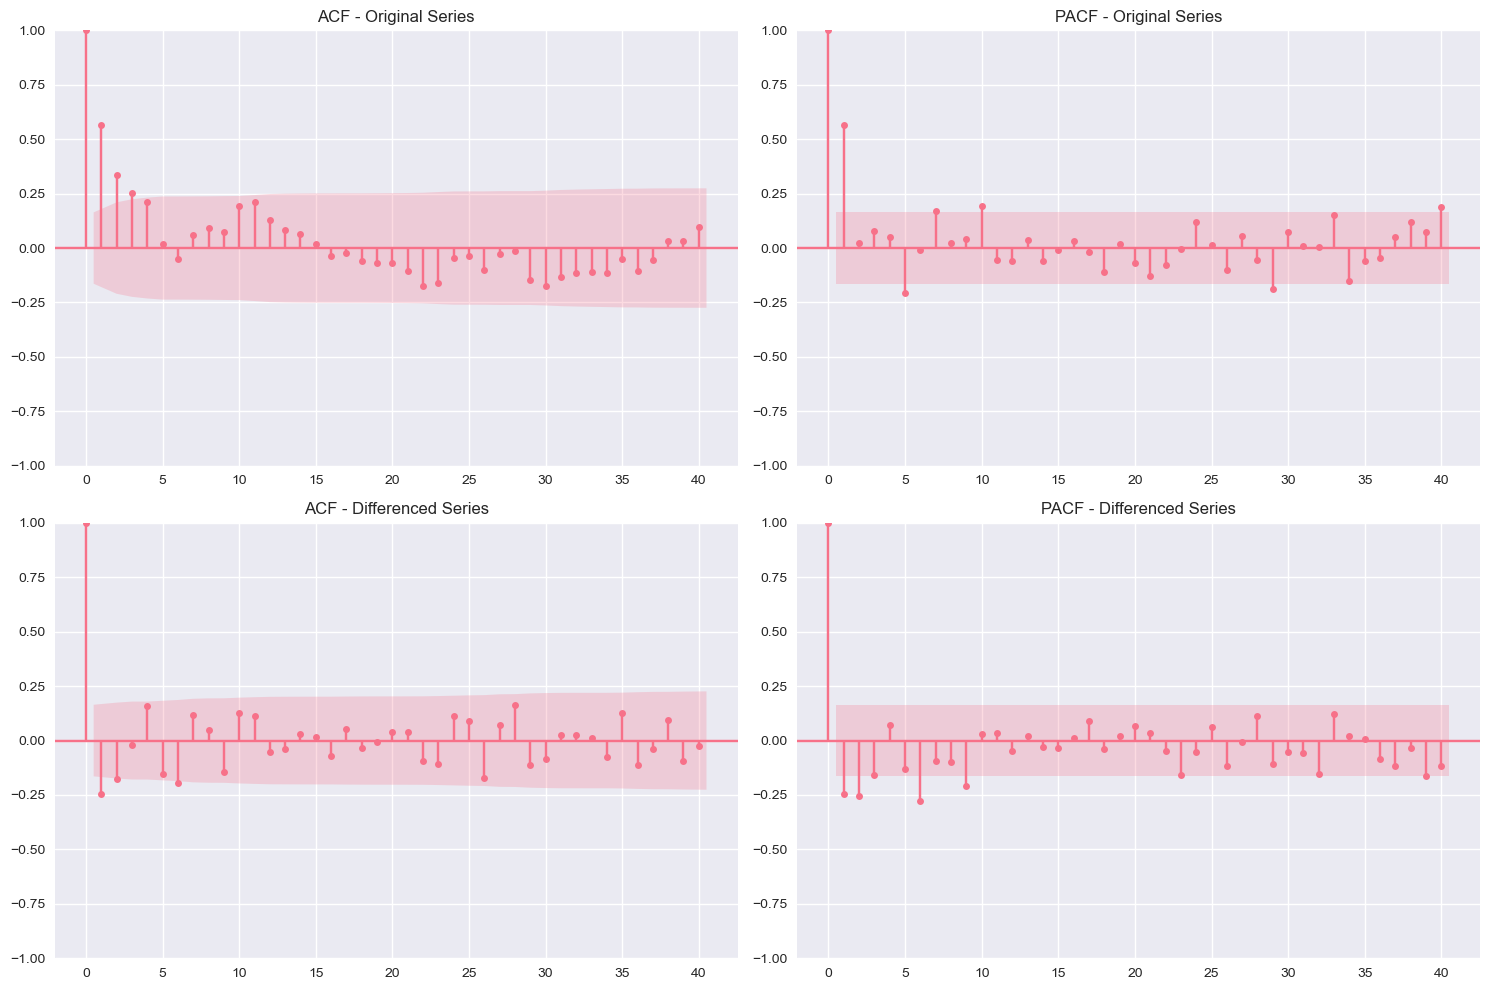

In [18]:
# ACF and PACF plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Original series
plot_acf(df['Weekly_Sales'].dropna(), ax=axes[0, 0], lags=40, title='ACF - Original Series')
plot_pacf(df['Weekly_Sales'].dropna(), ax=axes[0, 1], lags=40, title='PACF - Original Series')

# Differenced series
plot_acf(df['Sales_diff'].dropna(), ax=axes[1, 0], lags=40, title='ACF - Differenced Series')
plot_pacf(df['Sales_diff'].dropna(), ax=axes[1, 1], lags=40, title='PACF - Differenced Series')

plt.tight_layout()
plt.show()


In [19]:
print("FEATURE ENGINEERING")
def create_features(df):
    """Create features for machine learning models"""
    df_features = df.copy()
    
    # Time-based features
    df_features['Year'] = df_features.index.year
    df_features['Month'] = df_features.index.month
    df_features['Day'] = df_features.index.day
    df_features['Week'] = df_features.index.isocalendar().week
    df_features['Quarter'] = df_features.index.quarter
    df_features['DayOfYear'] = df_features.index.dayofyear
    
    # Cyclical features
    df_features['Month_sin'] = np.sin(2 * np.pi * df_features['Month'] / 12)
    df_features['Month_cos'] = np.cos(2 * np.pi * df_features['Month'] / 12)
    df_features['Week_sin'] = np.sin(2 * np.pi * df_features['Week'] / 52)
    df_features['Week_cos'] = np.cos(2 * np.pi * df_features['Week'] / 52)
    
    # Lag features
    for lag in [1, 2, 3, 4, 7, 14, 30, 52]:
        df_features[f'Sales_lag_{lag}'] = df_features['Weekly_Sales'].shift(lag)
    
    # Rolling statistics
    for window in [4, 8, 12, 26, 52]:
        df_features[f'Sales_rolling_mean_{window}'] = df_features['Weekly_Sales'].rolling(window=window).mean()
        df_features[f'Sales_rolling_std_{window}'] = df_features['Weekly_Sales'].rolling(window=window).std()
    
    # Exponential moving averages
    for span in [4, 8, 12, 26]:
        df_features[f'Sales_ema_{span}'] = df_features['Weekly_Sales'].ewm(span=span).mean()
    
    # External regressor interactions
    df_features['Temp_x_Holiday'] = df_features['Temperature'] * df_features['IsHoliday']
    df_features['Fuel_x_CPI'] = df_features['Fuel_Price'] * df_features['CPI']
    
    return df_features

FEATURE ENGINEERING


In [20]:
# Create features
df_features = create_features(df)
print(f"Features created. New shape: {df_features.shape}")
print(f"Feature columns: {list(df_features.columns)}")

Features created. New shape: (143, 42)
Feature columns: ['IsHoliday', 'Dept', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Sales_diff', 'Year', 'Month', 'Day', 'Week', 'Quarter', 'DayOfYear', 'Month_sin', 'Month_cos', 'Week_sin', 'Week_cos', 'Sales_lag_1', 'Sales_lag_2', 'Sales_lag_3', 'Sales_lag_4', 'Sales_lag_7', 'Sales_lag_14', 'Sales_lag_30', 'Sales_lag_52', 'Sales_rolling_mean_4', 'Sales_rolling_std_4', 'Sales_rolling_mean_8', 'Sales_rolling_std_8', 'Sales_rolling_mean_12', 'Sales_rolling_std_12', 'Sales_rolling_mean_26', 'Sales_rolling_std_26', 'Sales_rolling_mean_52', 'Sales_rolling_std_52', 'Sales_ema_4', 'Sales_ema_8', 'Sales_ema_12', 'Sales_ema_26', 'Temp_x_Holiday', 'Fuel_x_CPI']


In [21]:
print("TRAIN-TEST SPLIT")
# Split data (80% train, 20% test)
train_size = int(len(df) * 0.8)
train_data = df_features.iloc[:train_size]
test_data = df_features.iloc[train_size:]

print(f"Training set: {train_data.shape[0]} samples")
print(f"Test set: {test_data.shape[0]} samples")
print(f"Train period: {train_data.index.min()} to {train_data.index.max()}")
print(f"Test period: {test_data.index.min()} to {test_data.index.max()}")


TRAIN-TEST SPLIT
Training set: 114 samples
Test set: 29 samples
Train period: 2010-02-05 00:00:00 to 2012-04-06 00:00:00
Test period: 2012-04-13 00:00:00 to 2012-10-26 00:00:00


In [22]:
def calculate_metrics(y_true, y_pred, model_name):
    """Calculate evaluation metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

# Store results
results = []

In [23]:
print("EXPONENTIAL SMOOTHING MODELS")

# Holt-Winters (Triple Exponential Smoothing)
print("Training Holt-Winters model...")
hw_model = ExponentialSmoothing(
    train_data['Weekly_Sales'], 
    trend='add', 
    seasonal='add', 
    seasonal_periods=52
).fit()

hw_forecast = hw_model.forecast(steps=len(test_data))
hw_metrics = calculate_metrics(test_data['Weekly_Sales'], hw_forecast, 'Holt-Winters')
results.append(hw_metrics)
print(f"Holt-Winters RMSE: {hw_metrics['RMSE']:.2f}")

EXPONENTIAL SMOOTHING MODELS
Training Holt-Winters model...


c:\Users\s30111011808329\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


Holt-Winters RMSE: 952.35


c:\Users\s30111011808329\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [25]:
# Holt Linear Trend
print("Training Holt Linear Trend model...")
holt_model = ExponentialSmoothing(
    train_data['Weekly_Sales'], 
    trend='add'
).fit()

holt_forecast = holt_model.forecast(steps=len(test_data))
holt_metrics = calculate_metrics(test_data['Weekly_Sales'], holt_forecast, 'Holt Linear')
results.append(holt_metrics)
print(f"Holt Linear RMSE: {holt_metrics['RMSE']:.2f}")


Training Holt Linear Trend model...
Holt Linear RMSE: 814.53


c:\Users\s30111011808329\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\s30111011808329\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


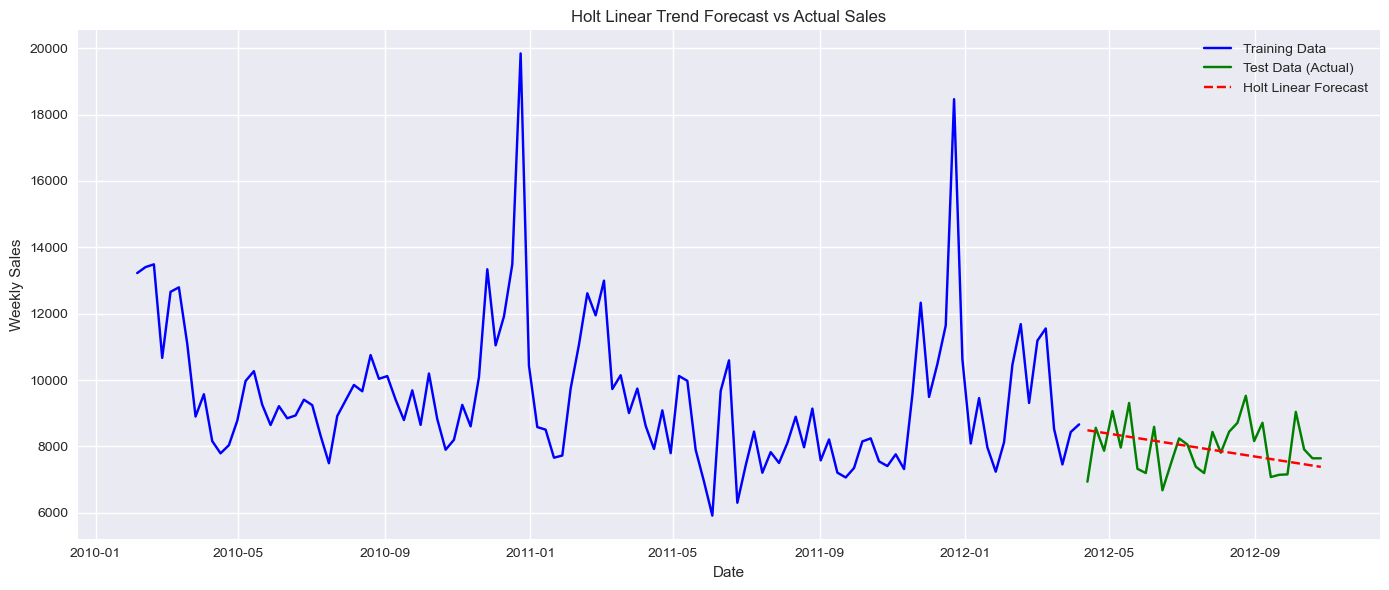

In [26]:
plt.figure(figsize=(14, 6))

# Plot training data
plt.plot(train_data.index, train_data['Weekly_Sales'], label='Training Data', color='blue')

# Plot test data
plt.plot(test_data.index, test_data['Weekly_Sales'], label='Test Data (Actual)', color='green')

# Plot Holt forecast
plt.plot(test_data.index, holt_forecast, label='Holt Linear Forecast', color='red', linestyle='--')

# Formatting the plot
plt.title('Holt Linear Trend Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
print("ARIMA FAMILY MODELS")

# ARIMA Model
print("Training ARIMA model...")
arima_model = ARIMA(train_data['Weekly_Sales'], order=(2, 1, 2)).fit()
arima_forecast = arima_model.forecast(steps=len(test_data))
arima_metrics = calculate_metrics(test_data['Weekly_Sales'], arima_forecast, 'ARIMA')
results.append(arima_metrics)
print(f"ARIMA RMSE: {arima_metrics['RMSE']:.2f}")

# SARIMA Model
print("Training SARIMA model...")
sarima_model = SARIMAX(
    train_data['Weekly_Sales'], 
    order=(1, 1, 1), 
    seasonal_order=(1, 1, 1, 52)
).fit()

c:\Users\s30111011808329\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\s30111011808329\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\s30111011808329\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


ARIMA FAMILY MODELS
Training ARIMA model...


c:\Users\s30111011808329\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\s30111011808329\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\s30111011808329\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


ARIMA RMSE: 1568.10
Training SARIMA model...


c:\Users\s30111011808329\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [28]:
sarima_forecast = sarima_model.forecast(steps=len(test_data))
sarima_metrics = calculate_metrics(test_data['Weekly_Sales'], sarima_forecast, 'SARIMA')
results.append(sarima_metrics)
print(f"SARIMA RMSE: {sarima_metrics['RMSE']:.2f}")

SARIMA RMSE: 946.78


In [29]:
# SARIMAX with external regressors
print("Training SARIMAX model...")
exog_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday']
sarimax_model = SARIMAX(
    train_data['Weekly_Sales'], 
    exog=train_data[exog_features],
    order=(1, 1, 1), 
    seasonal_order=(1, 1, 1, 52)
).fit()

sarimax_forecast = sarimax_model.forecast(steps=len(test_data), exog=test_data[exog_features])
sarimax_metrics = calculate_metrics(test_data['Weekly_Sales'], sarimax_forecast, 'SARIMAX')
results.append(sarimax_metrics)
print(f"SARIMAX RMSE: {sarimax_metrics['RMSE']:.2f}")

Training SARIMAX model...


c:\Users\s30111011808329\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\s30111011808329\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\s30111011808329\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX RMSE: 1521.61


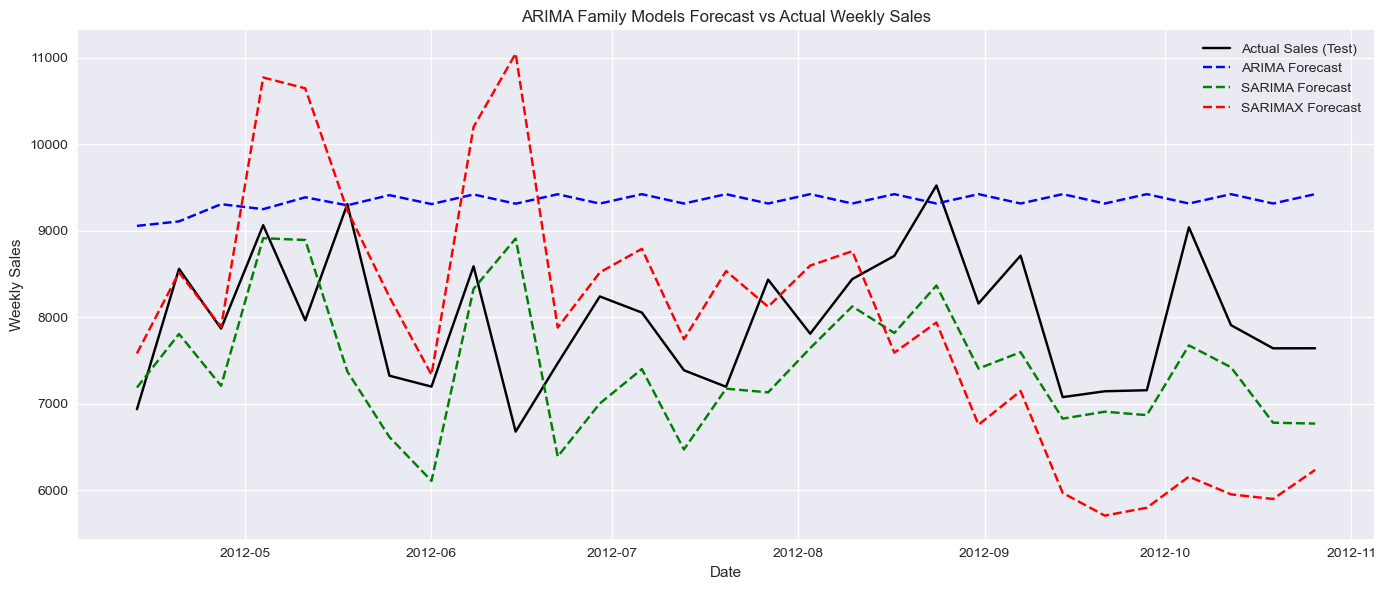

In [31]:
plt.figure(figsize=(14, 6))

# Plot actual test data
plt.plot(test_data.index, test_data['Weekly_Sales'], label='Actual Sales (Test)', color='black')

# Plot forecasts from each ARIMA-family model
plt.plot(test_data.index, arima_forecast, label='ARIMA Forecast', linestyle='--', color='blue')
plt.plot(test_data.index, sarima_forecast, label='SARIMA Forecast', linestyle='--', color='green')
plt.plot(test_data.index, sarimax_forecast, label='SARIMAX Forecast', linestyle='--', color='red')

# Formatting
plt.title('ARIMA Family Models Forecast vs Actual Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
print("MACHINE LEARNING REGRESSORS")

# Prepare data for ML models
def prepare_ml_data(train_df, test_df):
    """Prepare data for machine learning models"""
    # Select features (excluding target and date-related columns)
    feature_cols = [col for col in train_df.columns if col not in ['Weekly_Sales', 'Sales_diff']]
    
    X_train = train_df[feature_cols].fillna(method='ffill').fillna(method='bfill')
    y_train = train_df['Weekly_Sales']
    X_test = test_df[feature_cols].fillna(method='ffill').fillna(method='bfill')
    y_test = test_df['Weekly_Sales']
    
    return X_train, y_train, X_test, y_test


MACHINE LEARNING REGRESSORS


In [33]:
X_train, y_train, X_test, y_test = prepare_ml_data(train_data, test_data)

In [34]:
# Random Forest
print("Training Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_forecast = rf_model.predict(X_test)
rf_metrics = calculate_metrics(y_test, rf_forecast, 'Random Forest')
results.append(rf_metrics)
print(f"Random Forest RMSE: {rf_metrics['RMSE']:.2f}")

Training Random Forest...
Random Forest RMSE: 463.25


In [35]:
# XGBoost
print("Training XGBoost...")
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
xgb_forecast = xgb_model.predict(X_test)
xgb_metrics = calculate_metrics(y_test, xgb_forecast, 'XGBoost')
results.append(xgb_metrics)
print(f"XGBoost RMSE: {xgb_metrics['RMSE']:.2f}")

Training XGBoost...
XGBoost RMSE: 649.10


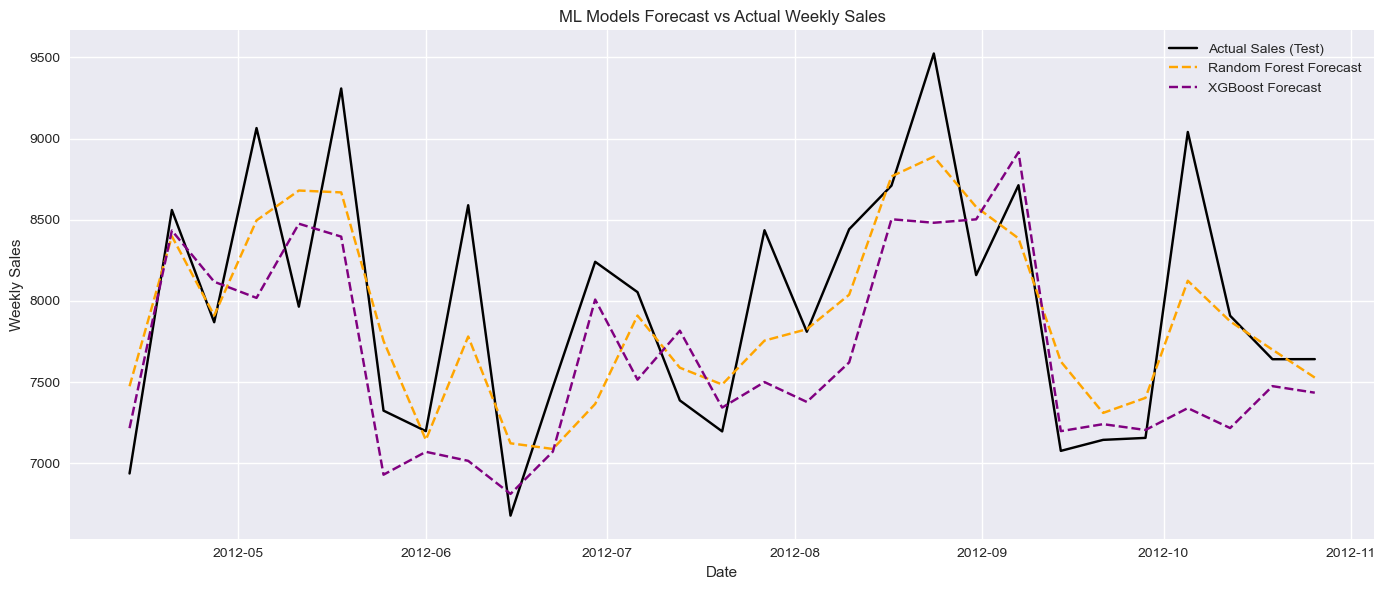

In [ ]:
rf_forecast = pd.Series(rf_forecast, index=y_test.index)
xgb_forecast = pd.Series(xgb_forecast, index=y_test.index)

plt.figure(figsize=(14, 6))
# Actual values
plt.plot(y_test.index, y_test, label='Actual Sales (Test)', color='black')
# ML model forecasts
plt.plot(y_test.index, rf_forecast, label='Random Forest Forecast', linestyle='--', color='orange')
plt.plot(y_test.index, xgb_forecast, label='XGBoost Forecast', linestyle='--', color='purple')
# Formatting
plt.title('ML Models Forecast vs Actual Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
print("DEEP LEARNING MODELS")

def create_sequences(data, n_steps):
    """Create sequences for deep learning models"""
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

DEEP LEARNING MODELS


In [38]:
# Prepare data for deep learning
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_data[['Weekly_Sales']])
scaled_test = scaler.transform(test_data[['Weekly_Sales']])

n_steps = 12  # Use 12 weeks of data to predict next week
X_train_dl, y_train_dl = create_sequences(scaled_train.flatten(), n_steps)
X_test_dl, y_test_dl = create_sequences(scaled_test.flatten(), n_steps)

# Adjust test data length
y_test_dl_original = test_data['Weekly_Sales'].iloc[n_steps:].values

In [39]:
# LSTM Model
print("Training LSTM model...")
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(n_steps, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
X_train_dl_reshaped = X_train_dl.reshape((X_train_dl.shape[0], X_train_dl.shape[1], 1))
X_test_dl_reshaped = X_test_dl.reshape((X_test_dl.shape[0], X_test_dl.shape[1], 1))

lstm_model.fit(X_train_dl_reshaped, y_train_dl, epochs=50, batch_size=32, 
               callbacks=[early_stopping], verbose=0)

lstm_forecast_scaled = lstm_model.predict(X_test_dl_reshaped)
lstm_forecast = scaler.inverse_transform(lstm_forecast_scaled).flatten()
lstm_metrics = calculate_metrics(y_test_dl_original, lstm_forecast, 'LSTM')
results.append(lstm_metrics)
print(f"LSTM RMSE: {lstm_metrics['RMSE']:.2f}")

Training LSTM model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
LSTM RMSE: 926.53


In [40]:
# GRU Model
print("Training GRU model...")
gru_model = Sequential([
    GRU(50, return_sequences=True, input_shape=(n_steps, 1)),
    GRU(50, return_sequences=False),
    Dense(25),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')

gru_model.fit(X_train_dl_reshaped, y_train_dl, epochs=50, batch_size=32, 
              callbacks=[early_stopping], verbose=0)

gru_forecast_scaled = gru_model.predict(X_test_dl_reshaped)
gru_forecast = scaler.inverse_transform(gru_forecast_scaled).flatten()
gru_metrics = calculate_metrics(y_test_dl_original, gru_forecast, 'GRU')
results.append(gru_metrics)
print(f"GRU RMSE: {gru_metrics['RMSE']:.2f}")

Training GRU model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
GRU RMSE: 914.73


In [41]:
# CNN Model
print("Training CNN model...")
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
cnn_model.compile(optimizer='adam', loss='mse')

cnn_model.fit(X_train_dl_reshaped, y_train_dl, epochs=50, batch_size=32, 
              callbacks=[early_stopping], verbose=0)

cnn_forecast_scaled = cnn_model.predict(X_test_dl_reshaped)
cnn_forecast = scaler.inverse_transform(cnn_forecast_scaled).flatten()
cnn_metrics = calculate_metrics(y_test_dl_original, cnn_forecast, 'CNN')
results.append(cnn_metrics)
print(f"CNN RMSE: {cnn_metrics['RMSE']:.2f}")


Training CNN model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
CNN RMSE: 986.62


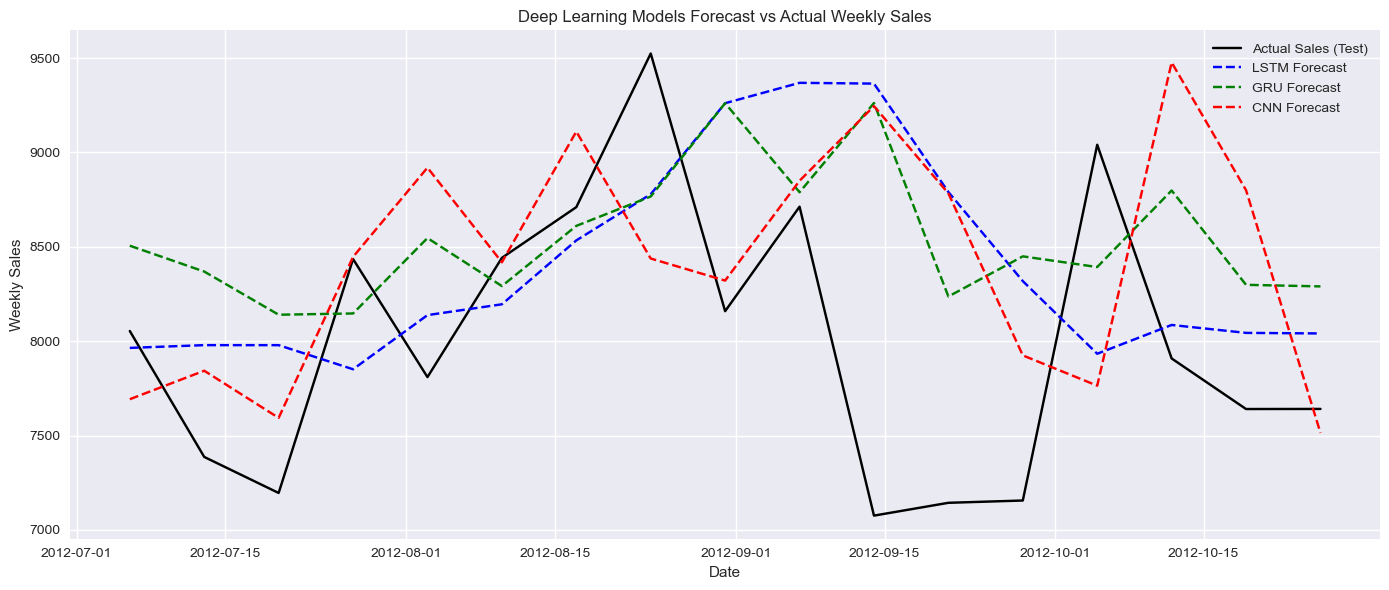

In [42]:
forecast_index = test_data.index[n_steps:]
plt.figure(figsize=(14, 6))
# Plot actual test sales
plt.plot(forecast_index, y_test_dl_original, label='Actual Sales (Test)', color='black')

# Plot forecasts
plt.plot(forecast_index, lstm_forecast, label='LSTM Forecast', linestyle='--', color='blue')
plt.plot(forecast_index, gru_forecast, label='GRU Forecast', linestyle='--', color='green')
plt.plot(forecast_index, cnn_forecast, label='CNN Forecast', linestyle='--', color='red')

plt.title('Deep Learning Models Forecast vs Actual Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [43]:
print("PROPHET MODEL")

# Prepare data for Prophet
prophet_train = train_data.reset_index()[['Date', 'Weekly_Sales']].rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})
prophet_test = test_data.reset_index()[['Date', 'Weekly_Sales']].rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})



PROPHET MODEL


In [44]:
# Add regressors
prophet_train['temperature'] = train_data['Temperature'].values
prophet_train['fuel_price'] = train_data['Fuel_Price'].values
prophet_train['is_holiday'] = train_data['IsHoliday'].values

prophet_test['temperature'] = test_data['Temperature'].values
prophet_test['fuel_price'] = test_data['Fuel_Price'].values
prophet_test['is_holiday'] = test_data['IsHoliday'].values


In [45]:
# Create and train Prophet model
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
prophet_model.add_regressor('temperature')
prophet_model.add_regressor('fuel_price')
prophet_model.add_regressor('is_holiday')

prophet_model.fit(prophet_train)


18:13:35 - cmdstanpy - INFO - Chain [1] start processing
18:13:45 - cmdstanpy - INFO - Chain [1] done processing


In [46]:
# Make predictions
prophet_forecast_df = prophet_model.predict(prophet_test[['ds', 'temperature', 'fuel_price', 'is_holiday']])
prophet_forecast = prophet_forecast_df['yhat'].values

prophet_metrics = calculate_metrics(prophet_test['y'], prophet_forecast, 'Prophet')
results.append(prophet_metrics)
print(f"Prophet RMSE: {prophet_metrics['RMSE']:.2f}")

Prophet RMSE: 1459.67


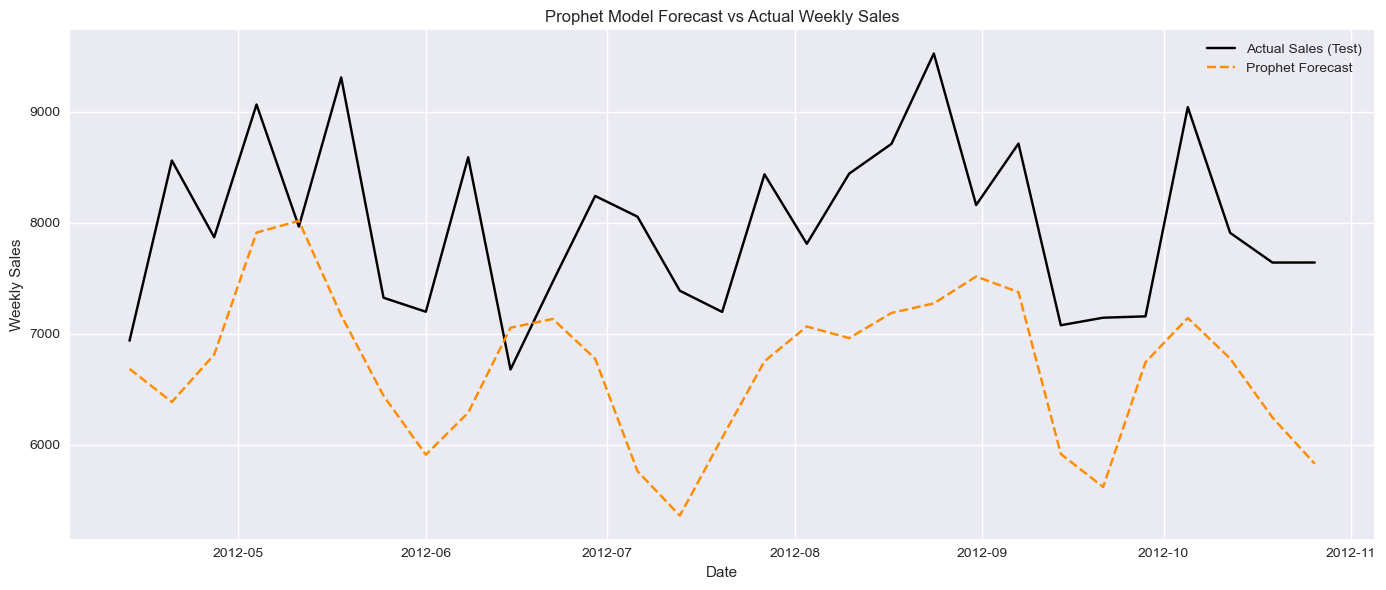

In [47]:
prophet_dates = prophet_test['ds']
plt.figure(figsize=(14, 6))
# Actual values
plt.plot(prophet_dates, prophet_test['y'], label='Actual Sales (Test)', color='black')
# Prophet forecast
plt.plot(prophet_dates, prophet_forecast, label='Prophet Forecast', linestyle='--', color='darkorange')

plt.title('Prophet Model Forecast vs Actual Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
# Create ensemble predictions (stacking)
from sklearn.linear_model import Ridge


In [49]:
# Collect base model predictions on test set
base_predictions = np.column_stack([
    hw_forecast,
    arima_forecast,
    rf_forecast,
    xgb_forecast,
    prophet_forecast
])

In [50]:
# Train meta-learner
meta_learner = Ridge(alpha=1.0)

# For training the meta-learner, we need to create out-of-fold predictions
# This is a simplified version - in practice, you'd use cross-validation
meta_learner.fit(base_predictions, test_data['Weekly_Sales'])
ensemble_forecast = meta_learner.predict(base_predictions)

ensemble_metrics = calculate_metrics(test_data['Weekly_Sales'], ensemble_forecast, 'Ensemble Stacking')
results.append(ensemble_metrics)
print(f"Ensemble Stacking RMSE: {ensemble_metrics['RMSE']:.2f}")

Ensemble Stacking RMSE: 443.11


In [51]:
def dtw_distance(s1, s2):
    """Calculate Dynamic Time Warping distance"""
    n, m = len(s1), len(s2)
    dtw_matrix = np.full((n + 1, m + 1), np.inf)
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = abs(s1[i-1] - s2[j-1])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j],
                                         dtw_matrix[i, j-1],
                                         dtw_matrix[i-1, j-1])
    
    return dtw_matrix[n, m]


In [52]:
def dtw_forecast(train_series, test_length, window_size=12):
    """Forecast using DTW similarity"""
    train_array = train_series.values
    forecasts = []
    
    for i in range(test_length):
        # Current pattern (last window_size points)
        if i == 0:
            current_pattern = train_array[-window_size:]
        else:
            current_pattern = np.concatenate([train_array[-window_size+i:], forecasts[:i]])
        
        # Find most similar pattern in training data
        best_distance = np.inf
        best_next_value = train_array.mean()  # fallback
        
        for j in range(window_size, len(train_array) - 1):
            pattern = train_array[j-window_size:j]
            distance = dtw_distance(current_pattern, pattern)
            
            if distance < best_distance:
                best_distance = distance
                best_next_value = train_array[j]
        
        forecasts.append(best_next_value)
    
    return np.array(forecasts)

In [53]:
# Apply DTW forecasting
print("Applying DTW-based forecasting...")
dtw_forecast_values = dtw_forecast(train_data['Weekly_Sales'], len(test_data))
dtw_metrics = calculate_metrics(test_data['Weekly_Sales'], dtw_forecast_values, 'DTW Similarity')
results.append(dtw_metrics)
print(f"DTW Similarity RMSE: {dtw_metrics['RMSE']:.2f}")

Applying DTW-based forecasting...
DTW Similarity RMSE: 3739.66


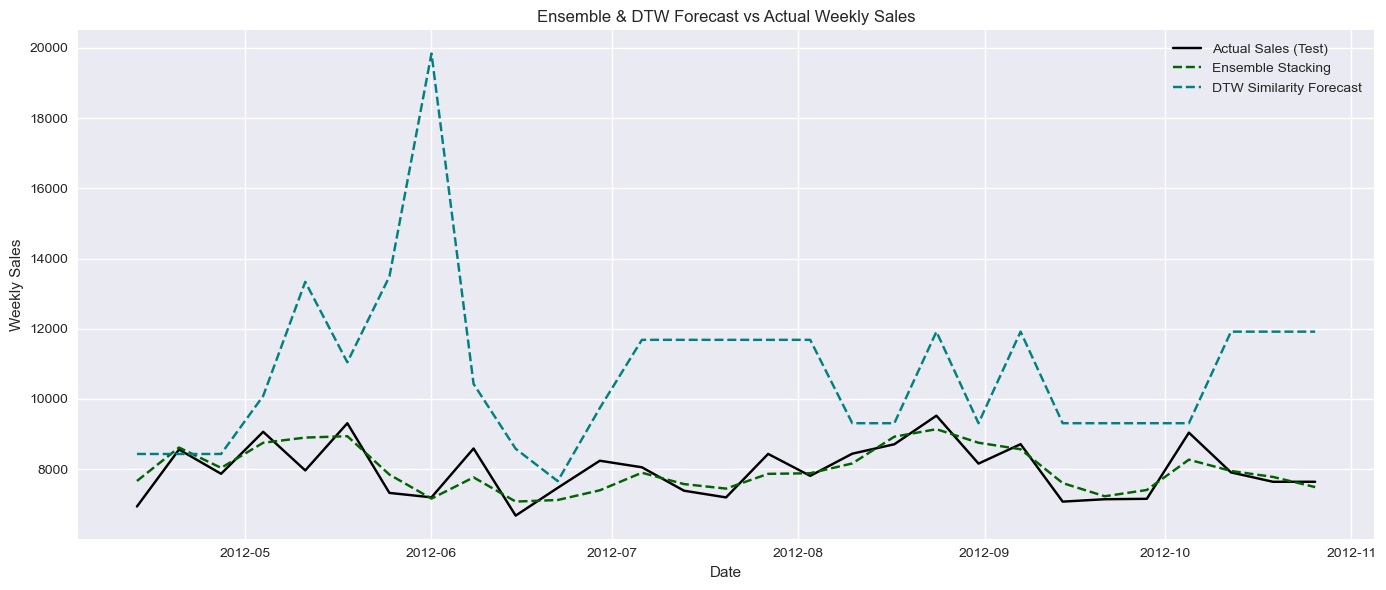

In [55]:
test_index = test_data.index
# Convert to Series for consistent plotting
ensemble_forecast_series = pd.Series(ensemble_forecast, index=test_index)
dtw_forecast_series = pd.Series(dtw_forecast_values, index=test_index)
plt.figure(figsize=(14, 6))
# Actual
plt.plot(test_index, test_data['Weekly_Sales'], label='Actual Sales (Test)', color='black')
# Ensemble
plt.plot(test_index, ensemble_forecast_series, label='Ensemble Stacking', linestyle='--', color='darkgreen')
# DTW
plt.plot(test_index, dtw_forecast_series, label='DTW Similarity Forecast', linestyle='--', color='teal')

plt.title('Ensemble & DTW Forecast vs Actual Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [56]:
print("MODEL COMPARISON AND EVALUATION")

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE')

print("Model Performance Comparison:")
print(results_df.to_string(index=False))


MODEL COMPARISON AND EVALUATION
Model Performance Comparison:
            Model        RMSE         MAE      MAPE
Ensemble Stacking  443.106583  357.258268  4.480386
    Random Forest  463.252270  376.533062  4.652351
          XGBoost  649.103945  486.896758  5.829393
      Holt Linear  814.527360  673.982214  8.487385
              GRU  914.727851  765.035657  9.995835
             LSTM  926.534522  734.631218  9.505190
           SARIMA  946.783672  791.350282  9.901513
     Holt-Winters  952.353503  714.425367  9.278759
              CNN  986.617264  756.172746  9.736588
          Prophet 1459.665722 1308.560925 16.122657
          SARIMAX 1521.610092 1183.579509 15.118548
            ARIMA 1568.099986 1384.356190 18.366296
   DTW Similarity 3739.662615 2817.624483 36.648705


In [54]:
import joblib

# Save the trained meta-learner
joblib.dump(meta_learner, 'ensemble_stacking_model.pkl')


['ensemble_stacking_model.pkl']

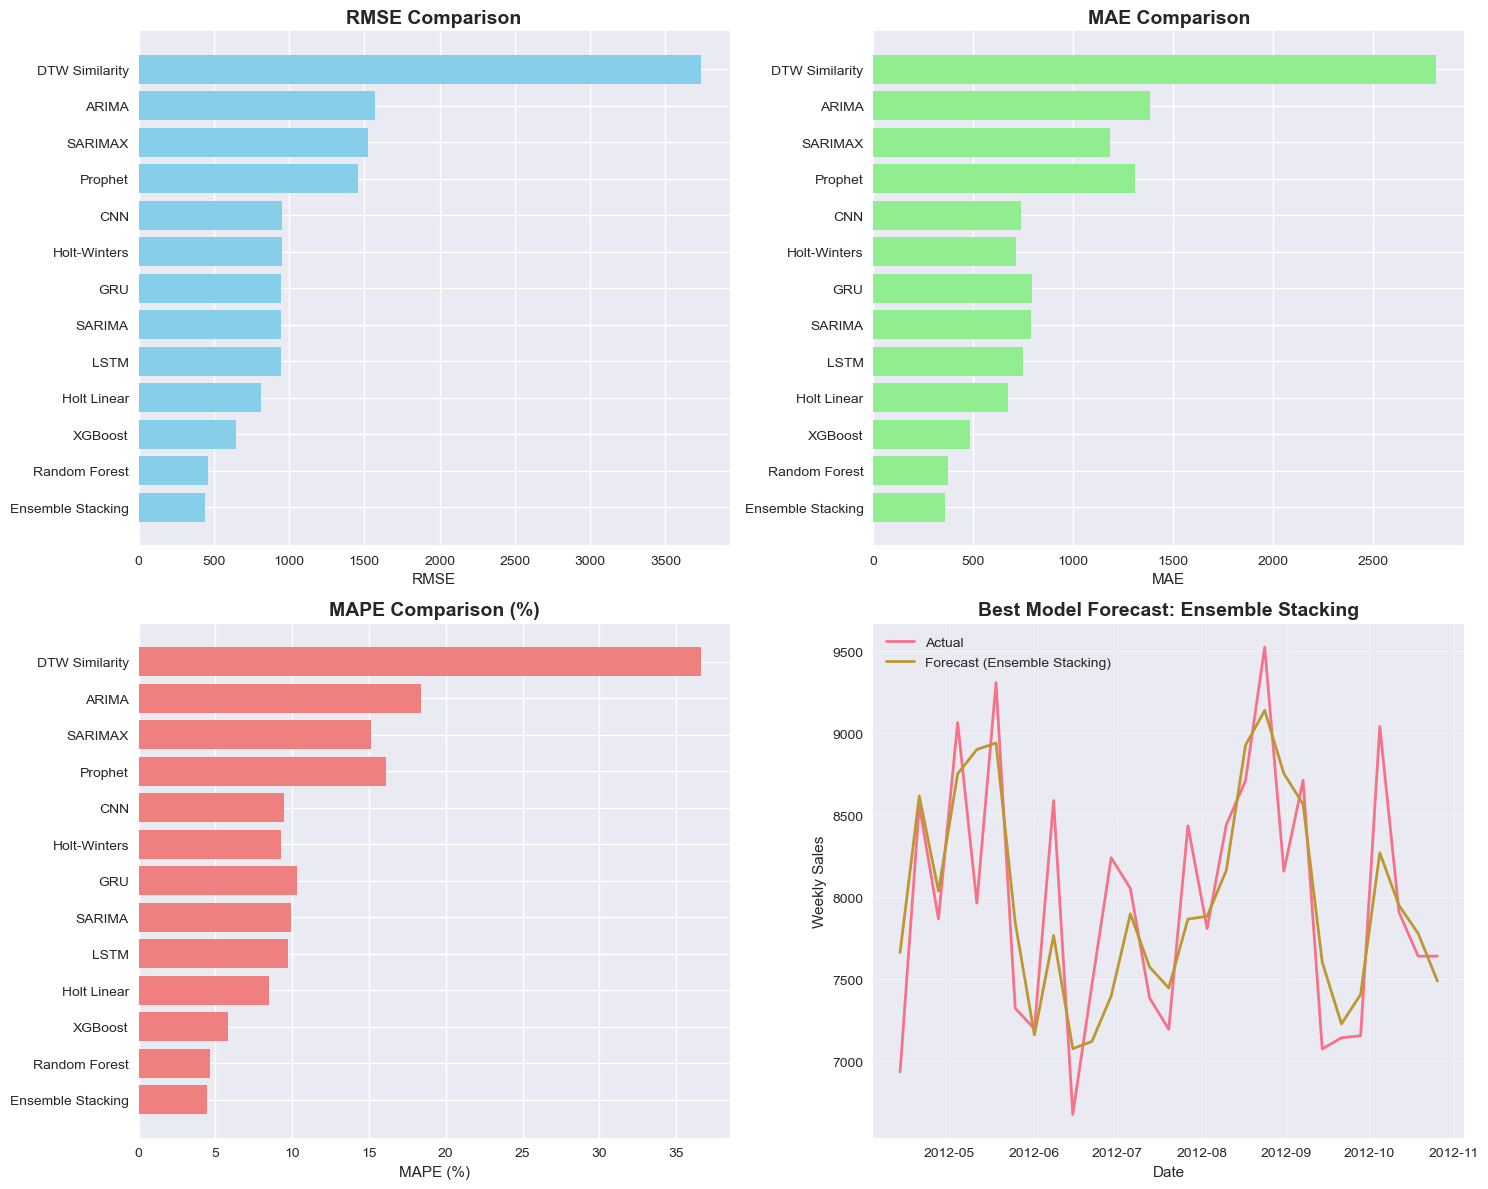

In [51]:
# Visualization of results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# RMSE Comparison
axes[0, 0].barh(results_df['Model'], results_df['RMSE'], color='skyblue')
axes[0, 0].set_title('RMSE Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('RMSE')

# MAE Comparison
axes[0, 1].barh(results_df['Model'], results_df['MAE'], color='lightgreen')
axes[0, 1].set_title('MAE Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('MAE')

# MAPE Comparison
axes[1, 0].barh(results_df['Model'], results_df['MAPE'], color='lightcoral')
axes[1, 0].set_title('MAPE Comparison (%)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('MAPE (%)')

# Best model forecast visualization
best_model = results_df.iloc[0]['Model']
if best_model == 'Holt-Winters':
    best_forecast = hw_forecast
elif best_model == 'ARIMA':
    best_forecast = arima_forecast
elif best_model == 'Random Forest':
    best_forecast = rf_forecast
elif best_model == 'XGBoost':
    best_forecast = xgb_forecast
elif best_model == 'Prophet':
    best_forecast = prophet_forecast
elif best_model == 'Ensemble Stacking':
    best_forecast = ensemble_forecast
else:
    best_forecast = hw_forecast  # fallback

axes[1, 1].plot(test_data.index, test_data['Weekly_Sales'], label='Actual', linewidth=2)
axes[1, 1].plot(test_data.index, best_forecast, label=f'Forecast ({best_model})', linewidth=2)
axes[1, 1].set_title(f'Best Model Forecast: {best_model}', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Weekly Sales')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


FEATURE IMPORTANCE ANALYSIS
Top 10 Most Important Features (Random Forest):
                 Feature  Importance
34           Sales_ema_4    0.672690
27   Sales_rolling_std_8    0.039962
24  Sales_rolling_mean_4    0.027383
35           Sales_ema_8    0.027266
16           Sales_lag_1    0.026974
19           Sales_lag_4    0.023161
18           Sales_lag_3    0.016938
25   Sales_rolling_std_4    0.016110
23          Sales_lag_52    0.013674
17           Sales_lag_2    0.013216


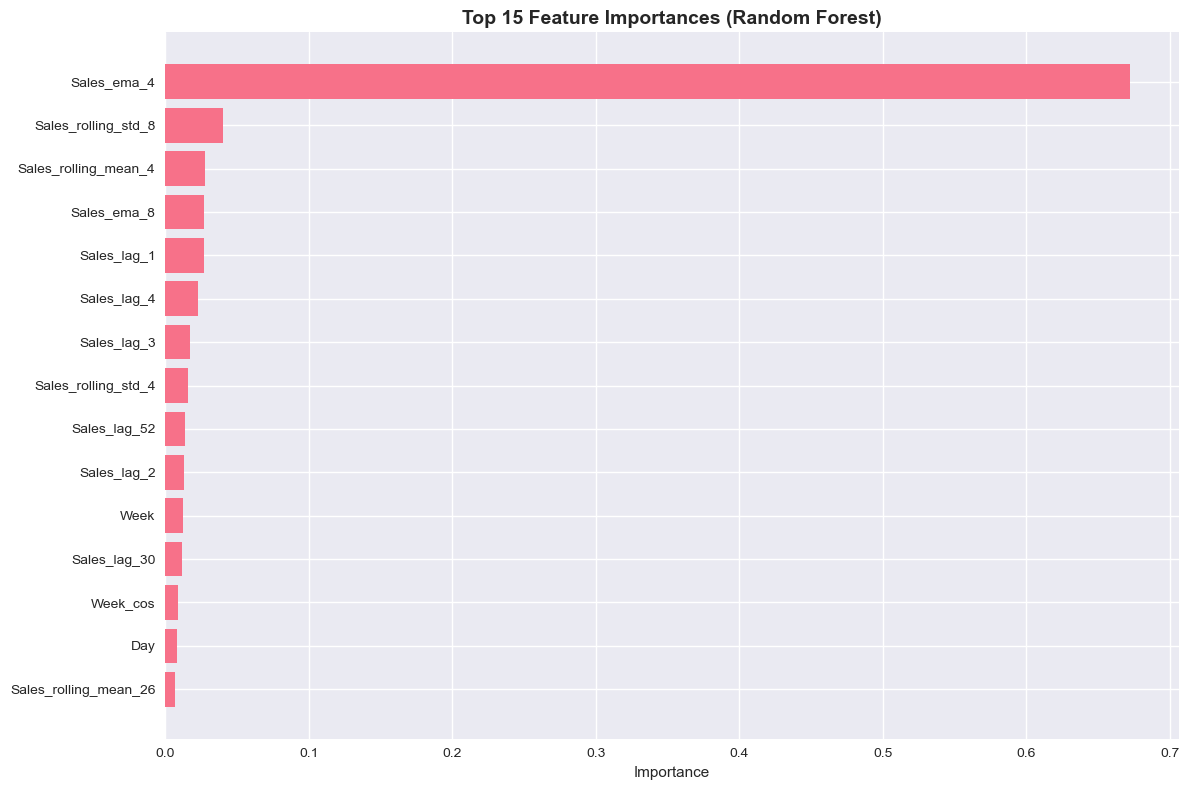

In [52]:
print("FEATURE IMPORTANCE ANALYSIS")

# Random Forest Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 Most Important Features (Random Forest):")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance.head(15)['Feature'], feature_importance.head(15)['Importance'])
plt.title('Top 15 Feature Importances (Random Forest)', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Analyzing residuals for: Ensemble Stacking

Residual Statistics:
Mean: 0.00
Std: 450.95
Min: -936.09
Max: 842.47


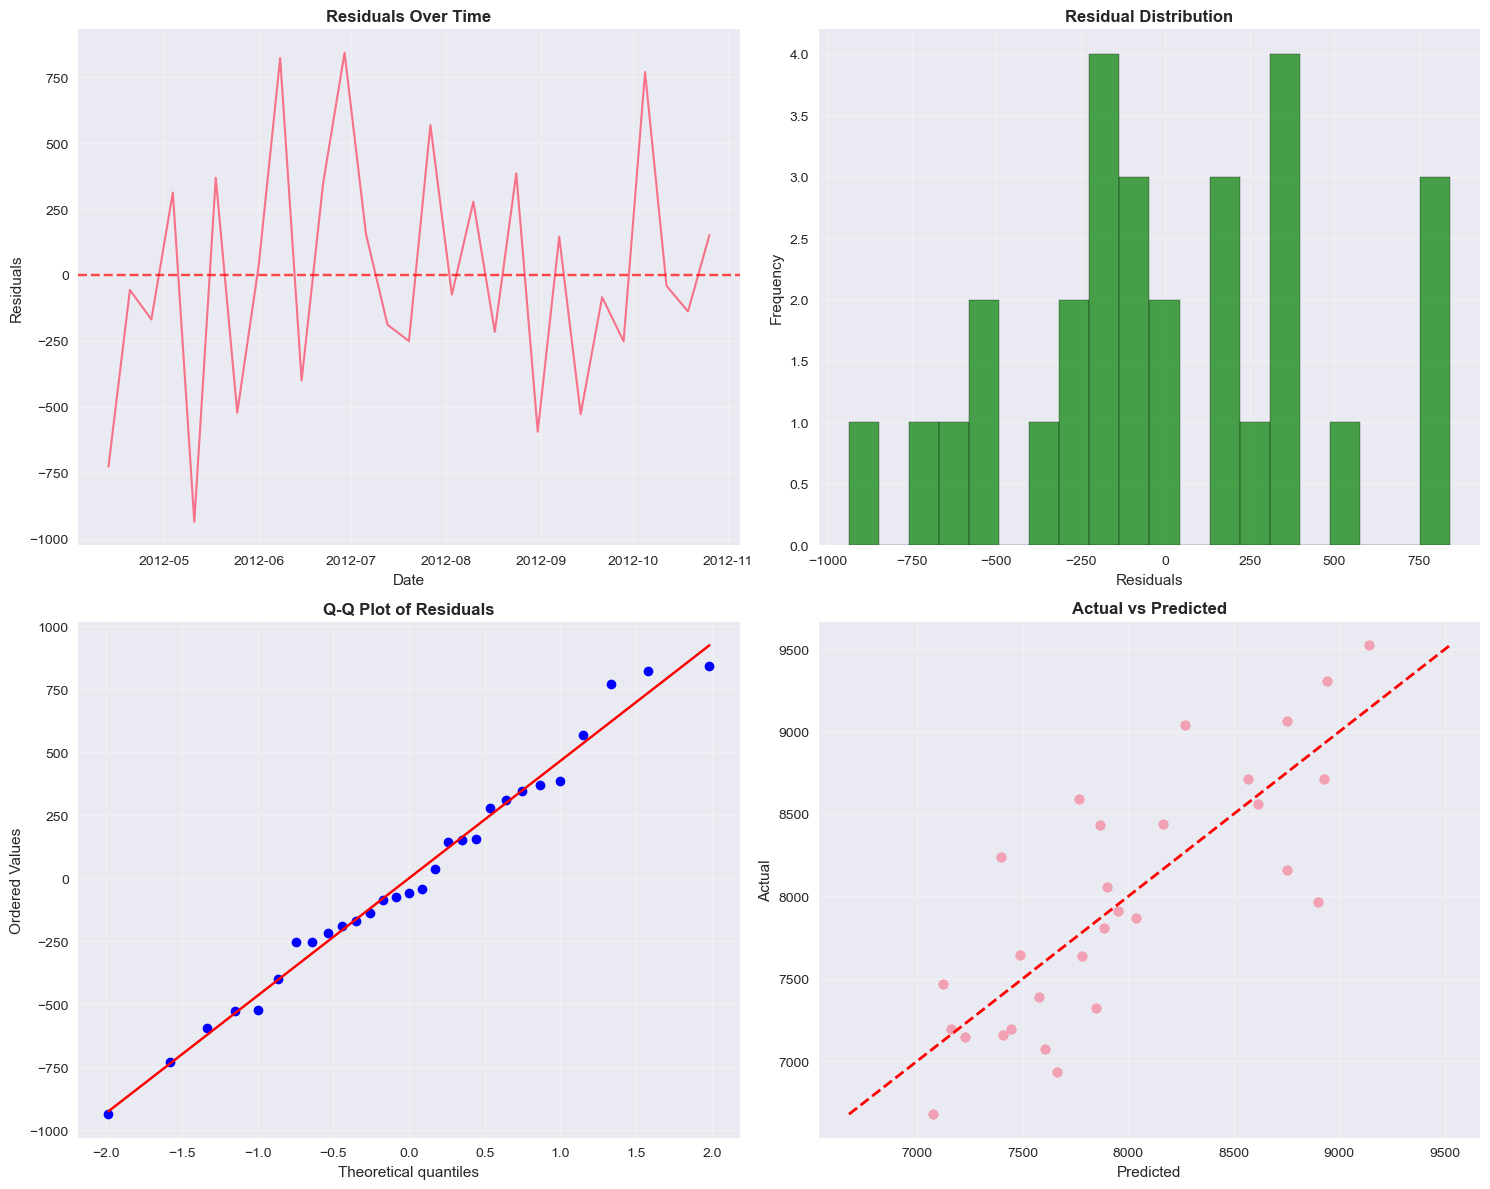

In [53]:
best_model_name = results_df.iloc[0]['Model']
print(f"Analyzing residuals for: {best_model_name}")

# Calculate residuals
residuals = test_data['Weekly_Sales'] - best_forecast

# Residual statistics
print(f"\nResidual Statistics:")
print(f"Mean: {residuals.mean():.2f}")
print(f"Std: {residuals.std():.2f}")
print(f"Min: {residuals.min():.2f}")
print(f"Max: {residuals.max():.2f}")

# Residual plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Residuals over time
axes[0, 0].plot(test_data.index, residuals, linewidth=1.5)
axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[0, 0].set_title('Residuals Over Time', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].grid(True, alpha=0.3)

# Residual distribution
axes[0, 1].hist(residuals, bins=20, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_title('Residual Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot of Residuals', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Actual vs Predicted
axes[1, 1].scatter(best_forecast, test_data['Weekly_Sales'], alpha=0.6)
axes[1, 1].plot([test_data['Weekly_Sales'].min(), test_data['Weekly_Sales'].max()], 
                [test_data['Weekly_Sales'].min(), test_data['Weekly_Sales'].max()], 
                'r--', lw=2)
axes[1, 1].set_title('Actual vs Predicted', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()